# Project C - Wavelets

In [1]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im

# Part 1 - Operators

# Q1 - Q3

See imagetools/projectC.py

Code is provided here for convenience

```
class Identity(LinearOperator):
    def __init__(self, shape):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
    def __call__(self, x):
        return x
    
    def adjoint(self, x):
        # note that the adjoint of the identity matrix is the identity matrix itself.
        # it is easy to see this by the definition of a linear operator, noting the commutative property of the inner product    
        return self.__call__(x)

    def gram(self, x):
        # apply the gram matrix to x, which is equivalent to just returning x
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        # do the inversion by the conjugate gradient
        return cg(lambda z: z + tau * self.gram(z), x)
    
class Convolution(LinearOperator):
    def __init__(self, shape, nu, separable=None):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)

        self._separable = separable
        n1, n2 = ishape[:2]
        self._nu_fft = kernel2fft(nu, n1, n2, separable=self._separable)
        # mu = F^{-1}(conjugate(F(nu))), see assignment 5 for explanation
        self._mu_fft = np.conjugate(self._nu_fft)
        
    def __call__(self, x):
        return convolvefft(x,self._nu_fft)
    
    def adjoint(self, x):
        return convolvefft(x, self._mu_fft)
    
    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to convolvefft(x, nu_fft*mu_fft) by properties of fft
        return convolvefft(x, nu_fft*mu_fft)
    
    def gram_resolvent(self, x, tau):
        # Assuming that boundary is always periodical
        # Just like the Gram LinearOperator, can do the inversion in the Fourier domain when periodical
        res_nu = 1 / (1 + tau * self._nu_fft * self._mu_fft)
        return convolvefft(x, res_nu)
    
class RandomMasking(LinearOperator):
    def __init__(self, shape, p):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
        self._apply_random_mask = np.random.choice(np.array([0,1]), size=oshape, p=[p,1-p])
        
    def __call__(self, x):
        # apply pixel by pixel the random mask
        return self._apply_random_mask * x
    
    def adjoint(self, x):
        # easy to see this is self-adjoint by the definition of a linear operator, noting the commutative property of the inner product 
        return self.__call__(x)

    def gram(self, x):
        # can also be reduced to self._apply_random_mask * x because 0*0=0, 1*0 =0, 0*1=0,1*1=1
        return self.__call__(self.adjoint(x))
    
    def gram_resolvent(self, x, tau):
        return cg(lambda z: z + tau * self.gram(z), x)
```

# Q4

In [2]:
starfish = plt.imread('assets/starfish.png')
x0 = starfish
motion_kernel = im.kernel('motion')

In [3]:
H_identity = im.Identity(x0.shape)
H_convolution = im.Convolution(x0.shape,nu=motion_kernel)
H_random_masking = im.RandomMasking(x0.shape,p=0.4)

In [4]:
y1, y2, y3 = H_identity(x0), H_convolution(x0), H_random_masking(x0)

images for Q4


/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


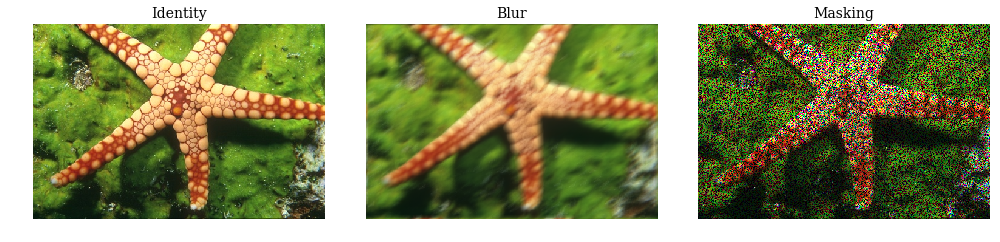

In [5]:
fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_title('Identity',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_title('Blur',fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].tick_params(axis='both', which='major', labelsize=10)
ax[2].set_title('Masking',fontdict = {'fontsize' : 14})
print('images for Q4')

# Q5 assert that〈Hx, y〉=〈x,H∗y〉for any arbitrary arrays x and y of shape H.ishape and H.oshape respectively 

In [6]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_adjoint(x,y,H):
    result = np.isclose(dot_product(H(x),y),dot_product(x,H.adjoint(y)))
    return result

In [7]:
def test_dotproduct_adjoint(totest):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 or 3 due to kernel2fft
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    # check for 1D
    if totest is 'Identity':
        H = operator(a)
    elif totest is 'RandomMasking':
        H = operator(a,p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(H.ishape)
        y = np.random.rand(H.oshape)
        print('1 dimensional case (int) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check corner case for 1D
    if totest is 'Identity':
        H = operator((a,))
    elif totest is 'RandomMasking':
        H = operator((a,),p=0.2)
        
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('1 dimensional case (tuple) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.2)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.2)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        y = np.random.rand(*H.oshape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H))

    # after 4D we can assume it generalizes

# Test run 1

In [8]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (397,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (397,) is does Identity test hold?  True
2 dimensional case - input shape is:  (397, 120) is does Identity test hold?  True
3 dimensional case - input shape is:  (397, 120, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (397, 120, 3, 3) is does Identity test hold?  True


In [9]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (174, 140) is does Convolution test hold?  True
3 dimensional case - input shape is:  (174, 140, 3) is does Convolution test hold?  True


In [10]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (309,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (309,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (309, 238) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (309, 238, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (309, 238, 1, 1) is does RandomMasking test hold?  True


# Test run 2

In [11]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (358,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (358,) is does Identity test hold?  True
2 dimensional case - input shape is:  (358, 256) is does Identity test hold?  True
3 dimensional case - input shape is:  (358, 256, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (358, 256, 1, 1) is does Identity test hold?  True


In [12]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (123, 179) is does Convolution test hold?  True
3 dimensional case - input shape is:  (123, 179, 1) is does Convolution test hold?  True


In [13]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (193,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (193,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (193, 256) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (193, 256, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (193, 256, 1, 1) is does RandomMasking test hold?  True


# Test run 3

In [14]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (223,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (223,) is does Identity test hold?  True
2 dimensional case - input shape is:  (223, 133) is does Identity test hold?  True
3 dimensional case - input shape is:  (223, 133, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (223, 133, 3, 1) is does Identity test hold?  True


In [15]:
test_dotproduct_adjoint('Convolution')

2 dimensional case - input shape is:  (366, 299) is does Convolution test hold?  True
3 dimensional case - input shape is:  (366, 299, 3) is does Convolution test hold?  True


In [16]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (381,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (381,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (381, 122) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (381, 122, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (381, 122, 1, 1) is does RandomMasking test hold?  True


# Q6.  Check also that Inverse(Id +τH∗H) (x+τH∗Hx) = x for any arbitrary image x of shape H.ishape.

## Methodology to check: multiply both sides by  Inverse(x+τH∗Hx).
## lhs = H.gram_resolvent applied to x + tau * H.adjoint(H(x))
## rhs = x

In [17]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_gram_resolvent_correct(H,x,tau):
    term = x + tau * H.adjoint(H(x))
    lhs = H.gram_resolvent(term,tau)
    rhs = x
    result = np.allclose(lhs,rhs)
    return result

In [18]:
def test_gram_resolvent(totest,tau):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # earlier dims between 100 and 400
    a,b = np.random.randint(100,high=400,size=2)
    # later dims need to be 1 to 4 due to fft in the frequency domain
    c,d = np.random.choice(np.array([1,3]), size=2, p=[.5,.5])
    
    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.6)
    x = np.random.rand(*H.ishape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.6)
    x = np.random.rand(*H.ishape)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.6)
    if totest is not 'Convolution':
        x = np.random.rand(*H.ishape)
        print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_gram_resolvent_correct(H,x,tau))

    # after 4D we can assume it generalizes

# Test run 1

In [19]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (189, 219) is does Identity test hold?  True
3 dimensional case - input shape is:  (189, 219, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (189, 219, 1, 3) is does Identity test hold?  True


In [20]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (276, 310) is does Convolution test hold?  True
3 dimensional case - input shape is:  (276, 310, 1) is does Convolution test hold?  True


In [21]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (223, 323) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (223, 323, 1) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (223, 323, 1, 3) is does RandomMasking test hold?  True


# Test run 2

In [22]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (284, 137) is does Identity test hold?  True
3 dimensional case - input shape is:  (284, 137, 1) is does Identity test hold?  True
4 dimensional case - input shape is:  (284, 137, 1, 3) is does Identity test hold?  True


In [23]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (282, 285) is does Convolution test hold?  True
3 dimensional case - input shape is:  (282, 285, 1) is does Convolution test hold?  True


In [24]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (111, 126) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (111, 126, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (111, 126, 3, 3) is does RandomMasking test hold?  True


# Test run 3

In [25]:
test_gram_resolvent('Identity',tau=2)

2 dimensional case - input shape is:  (200, 104) is does Identity test hold?  True
3 dimensional case - input shape is:  (200, 104, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (200, 104, 3, 1) is does Identity test hold?  True


In [26]:
test_gram_resolvent('Convolution',tau=2)

2 dimensional case - input shape is:  (292, 326) is does Convolution test hold?  True
3 dimensional case - input shape is:  (292, 326, 3) is does Convolution test hold?  True


In [27]:
test_gram_resolvent('RandomMasking',tau=2)

2 dimensional case - input shape is:  (327, 150) is does RandomMasking test hold?  True
3 dimensional case - input shape is:  (327, 150, 3) is does RandomMasking test hold?  True
4 dimensional case - input shape is:  (327, 150, 3, 3) is does RandomMasking test hold?  True


# Part 2 - Discrete Wavelet Transform

In [28]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im
import pywt
from numpy.linalg import inv

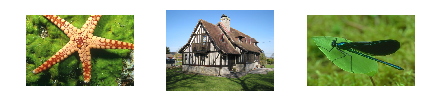

In [29]:
x0=plt.imread('assets/starfish.png')
y=plt.imread('assets/normandy.png')
z=plt.imread('assets/dragonfly.png')
fig, axes = plt.subplots(ncols=3)
im.show(x0, ax=axes[0])
im.show(y, ax=axes[1])
im.show(z, ax=axes[2])

# Q7,8 : Implement DWT function and display

Text(0.5,1,'Its wavelet Coefficient')

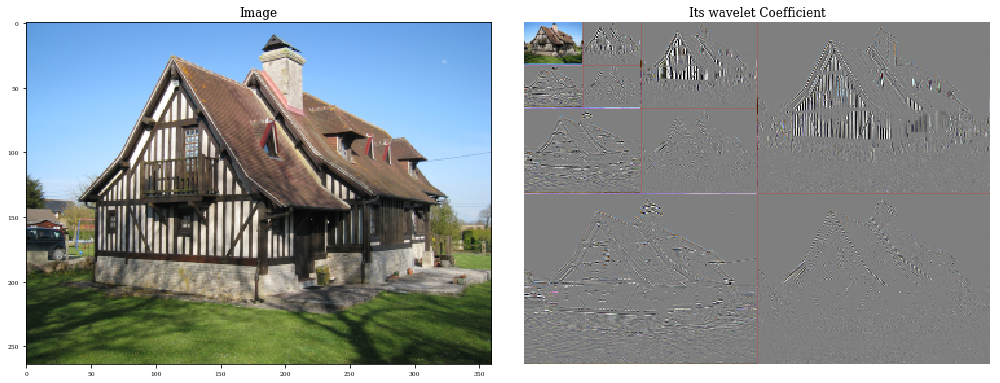

In [30]:
x0=plt.imread('assets/normandy.png')
h,g = im.wavelet('db2')
J=3
x= im.dtw_crop(x0,J)        # Crop x to size of DWT, J=3
z_dwt= im.dwt(x,J,h,g)         # dwt of x

fig, axs = plt.subplots(ncols=2,figsize=(14,6))
axs[0].imshow(x)
axs[0].set_title('Image')
im.showdwt(z_dwt, J)
axs[1].set_title('Its wavelet Coefficient')


# Q9: Implement IDWT function :
# Solved in ProjectC.py

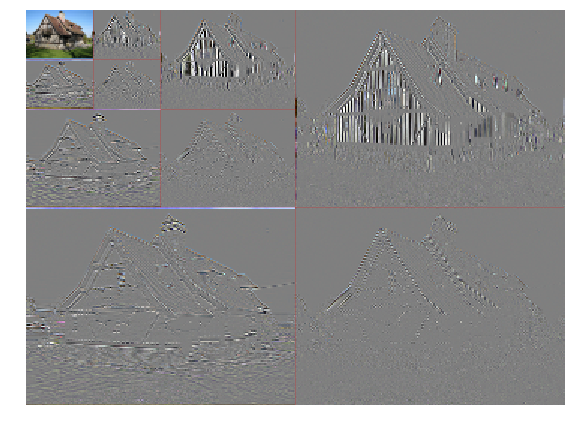

In [31]:
fig, axs = plt.subplots(figsize=(14,6))
im.showdwt(z_dwt,J,ax=axs)

# Q10: Check DWT and IDWT vs Inverse version
# DWT -> IDWT:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Display shows that the proof correctly


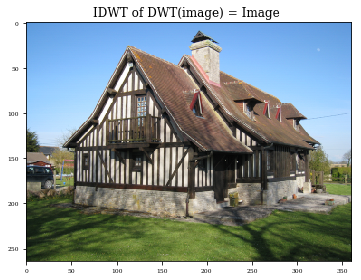

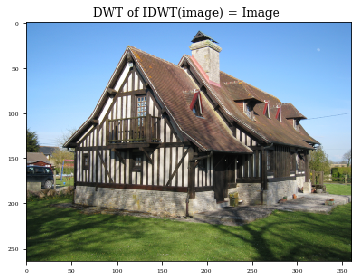

In [32]:
z_dwt= im.dwt(x,J,h,g) 
z_idwt = im.idwt(z_dwt,J,h,g)

fig, axs = plt.subplots()
axs.imshow(z_idwt)
axs.set_title('IDWT of DWT(image) = Image ')

     # IDWT -> DWT
x_idwt = im.idwt(x,J,h,g)
x= im.dwt(x_idwt,J,h,g) 
fig, axs = plt.subplots()
axs.imshow(x)
axs.set_title('DWT of IDWT(image) = Image ')
print('** Display shows that the proof correctly')


# Q11: Implement Invert() , Power(), use Class DWT :
# DWT -> IDWT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Invert() show the proof correctly
(264, 360, 3)
(264, 360, 3)
(264, 360, 1)
** np.isclose(p,p1)=True, shows that power(self) was implemented correctly to match with dwt_power(n1,n2,J)


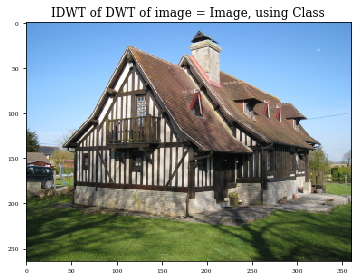

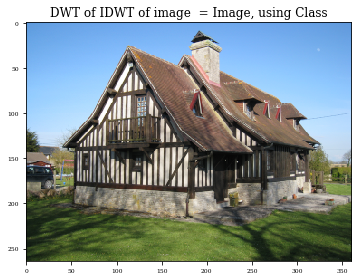

In [33]:
x0=plt.imread('assets/normandy.png')
W= im.DWT(x.shape,J, name='db2')  # Call Object W from class DWT
x0=im.dtw_crop(x0,J)
z_dwt = W(x0)                # Take DWT
x_idwt = W.invert(z_dwt)              # Take IDWT

fig, axs = plt.subplots()
axs.imshow(x_idwt)
axs.set_title('IDWT of DWT of image = Image, using Class')

        # DWT -> IDWT  
x_idwt = W.invert(x0)              # Take IDWT
x = W(x_idwt)             # Take DWT
fig, axs = plt.subplots()
axs.imshow(x)
axs.set_title('DWT of IDWT of image  = Image, using Class')

print('** Invert() show the proof correctly')

    # Check if Power(self) = dwt_power(n1,n2,J)
print(x0.shape)
x=im.dtw_crop(x0,J)
print(x.shape)
n1,n2= x.shape[:2]
p1= im.dwt_power(n1,n2,J,)
p= W.power()
print(p.shape)
#print(p1.shape)
#print(p[:,0])

np.isclose(p,p1)
print('** np.isclose(p,p1)=True, shows that power(self) was implemented correctly to match with dwt_power(n1,n2,J)')


# Q12: Thresholding ( refer to ProjectC.py)

# Q13: Denoise 

(320, 480, 3)


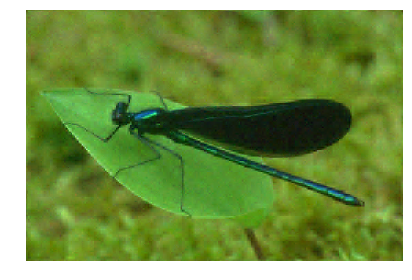

In [34]:
sig= 20/255
x=plt.imread('assets/dragonfly.png')
x0= im.dtw_crop(x,J)
y_noise= x0 + sig * np.random.randn(*x0.shape)
W= im.DWT(y_noise.shape,J, name='db2')             # Call Object W from class DWT

y_denoise = im.softthresh_denoise(y_noise, sig, W, alpha=10/255)
plt.figure()
im.show(y_denoise)
print(x0.shape)
#plt.figure()
#im.show(y_noise)

# Q14: Plot PSNR

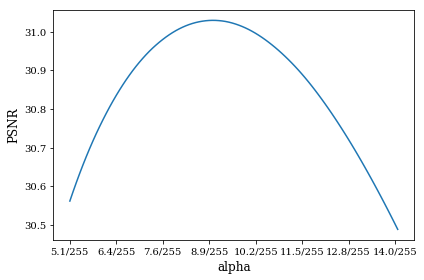

In [35]:
k=np.linspace(0,9,num=100)
psnrs= np.zeros(k.shape)
alpha= np.zeros(k.shape)

for i,num in enumerate(k):
    y_denoise= im.softthresh_denoise(y_noise, sig, W, alpha=(6+num)/255)
    psnrs[i] = im.psnr(x0,y_denoise)
    alpha[i] = (5.1+num)/255
    
def plot():
    fig, axs = plt.subplots()
    axs.plot(alpha,psnrs)
    axs.tick_params(axis='both', which='major', labelsize=10)
    axs.set_xlabel('alpha',fontdict = {'fontsize' : 12})
    axs.set_ylabel('PSNR',fontdict = {'fontsize' : 12})

    # get ticks
    a = axs.get_xticks().tolist()
    # convert ticks to str version
    a = ['{:.1f}/255'.format(i*255) for i in a]
    axs.set_xticklabels(a)
    
plot()

# Part 3 - Undecimated Discrete Wavelet Transform

In [36]:
import math 
import time
from collections import deque

# Q15

In [37]:
def udwt(x, J, h, g):
    if J == 0:
        return x[:, :, np.newaxis]
    tmph = np.swapaxes(im.convolve(np.swapaxes(x,0,1), h),0,1) / 2
    tmpg = np.swapaxes(im.convolve(np.swapaxes(x,0,1), g),0,1) / 2
    detail = np.stack((im.convolve(tmpg, h),
    im.convolve(tmph, g),
    im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = np.zeros((2*h.shape[0]-1,1))
    g2 = np.zeros((2*g.shape[0]-1,1))
    h2[::2] = h
    g2[::2] = g
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), detail), axis=2)
    return z

# Q16

In [38]:
h,g = im.wavelet('db2')
image_directory = 'assets/dragonfly.png'
x0 =  plt.imread(image_directory )

channel_1 = udwt(x0[:,:,0],3,h,g)
channel_2 = udwt(x0[:,:,1],3,h,g)
channel_3 = udwt(x0[:,:,2],3,h,g)

In [39]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(0.8,0.8))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

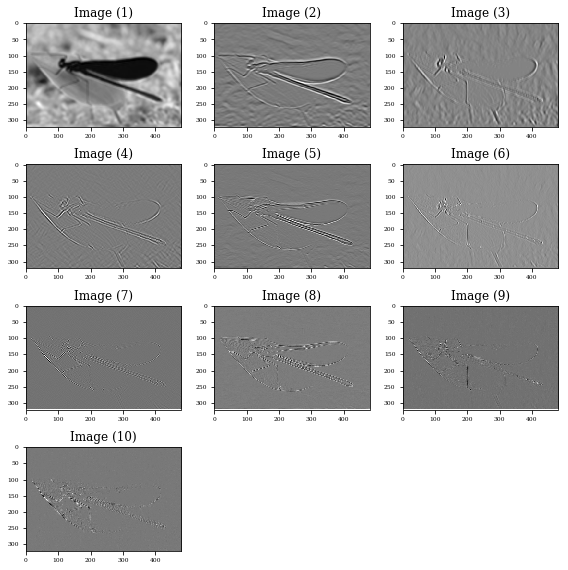

In [40]:
channel_1_images = []
for i in range(channel_1.shape[2]):
    channel_1_images.append(channel_1[:,:,i])
show_images(channel_1_images, cols = 4 )

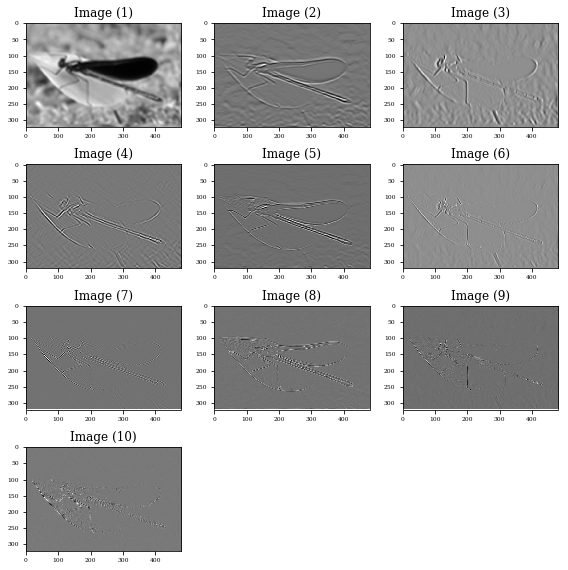

In [41]:
channel_2_images = []
for i in range(channel_2.shape[2]):
    channel_2_images.append(channel_2[:,:,i])
show_images(channel_2_images, cols = 4 )

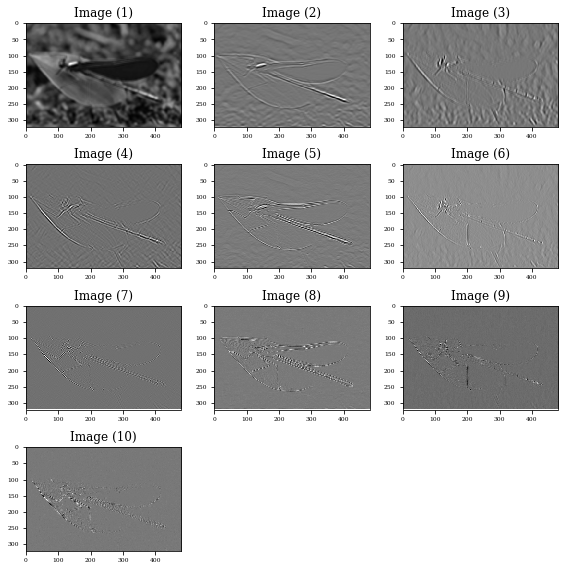

In [42]:
channel_3_images = []
for i in range(channel_3.shape[2]):
    channel_3_images.append(channel_3[:,:,i])
show_images(channel_3_images, cols = 4 )

DWT transforms discrete signal from time domain to frequency domain i.e., it provides time and
frequency representation of the signal. The signal to be decomposed is analyzed at different frequency
bands with different resolution. The decomposition takes place by transmitting the signal to a series of
HPF and LPF. In this case we used the Daubechies Wavelet, these are family of orthogonal wavelets defining a DWT and are characterized by a maximal number of vanishing moments for some given support, vanishing points correspond to better representation of more complex signals. For db2, the wavelets used in this case has 2 vanishing points, so the representative domian of those wavelets are higher than db1, which is reflected in the structure of the coefficients of the wavelet transform in this question. We can see at higher scales, the details captured are at a higher and higher resolution amongst the representation, this is due to the repeating low pass and high pass filtering performed at each scale in frequency space and decimation in image space. This results in all the possible combinations of low-pass and high-pass filtering as we increase in scale, which leads to better representation of the signal as we increase the complexity of the wavelet transform. In essence, the wavelet transform tries to combine the best of the frequency world and the spatial world by making a compromise between them in the form of the wavelets used. 

# Q17

In [43]:
def iudwt(z, J, h, g):
    if J == 0:
        return z[:, :, 0]
    h2 = np.zeros((2*h.shape[0]-1,1))
    g2 = np.zeros((2*g.shape[0]-1,1))
    h2[::2] = h
    g2[::2] = g
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + \
    im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + \
    im.convolve(z[:, :, -1], h[::-1])
    x = (np.swapaxes(im.convolve(np.swapaxes(tmpg,0,1), g[::-1]),0,1) + np.swapaxes(im.convolve(np.swapaxes(tmph,0,1),h[::-1]),0,1))/2
    return x

# Q18

In [44]:
J = 2

transform = udwt(x0[:,:,0], J, h, g)
inverse = iudwt(transform, J, h, g )
transform_again = udwt(inverse, J, h, g)
print('Check for left inverse(J = 2): ', np.allclose(x0[:,:,0], inverse))
print('Check for right inverse(J = 2): ', np.allclose(transform, transform_again))

J = 3

transform = udwt(x0[:,:,0], J, h, g)
inverse = iudwt(transform, J, h, g )
transform_again = udwt(inverse, J, h, g)
print('Check for left inverse(J = 3): ', np.allclose(x0[:,:,0], inverse))
print('Check for right inverse(J = 3): ', np.allclose(transform, transform_again))

J = 4

transform = udwt(x0[:,:,0], J, h, g)
inverse = iudwt(transform, J, h, g )
transform_again = udwt(inverse, J, h, g)
print('Check for left inverse(J = 4): ', np.allclose(x0[:,:,0], inverse))
print('Check for right inverse(J = 4): ', np.allclose(transform, transform_again))

Check for left inverse(J = 2):  True
Check for right inverse(J = 2):  False
Check for left inverse(J = 3):  True
Check for right inverse(J = 3):  False
Check for left inverse(J = 4):  True
Check for right inverse(J = 4):  False


In [45]:
image_directory = 'assets/starfish.png'
y0 =  plt.imread(image_directory)
image_directory = 'assets/dragonfly.png'
x0 =  plt.imread(image_directory )


filters = ['db1', 'db2', 'db4']

for i in filters:

    J = 2
    x = x0[:,:,0]
    y = udwt(y0[:,:,0],J,h,g)

    left_side = np.dot(udwt(x,J,h,g).flatten(),y.flatten())
    right_side = np.dot(x.flatten(), iudwt(y,J,h,g).flatten())
    print('Check iudwt is the adjoint of udwt(J = 2, Wavelet : %s):' %i, np.isclose(left_side, right_side))

    J = 3
    x = x0[:,:,0]
    y = udwt(y0[:,:,0],J,h,g)

    left_side = np.dot(udwt(x,J,h,g).flatten(),y.flatten())
    right_side = np.dot(x.flatten(), iudwt(y,J,h,g).flatten())
    print('Check iudwt is the adjoint of udwt(J = 3, Wavelet : %s):' %i, np.isclose(left_side, right_side))

    J = 4
    x = x0[:,:,0]
    y = udwt(y0[:,:,0],J,h,g)

    left_side = np.dot(udwt(x,J,h,g).flatten(),y.flatten())
    right_side = np.dot(x.flatten(), iudwt(y,J,h,g).flatten())
    print('Check iudwt is the adjoint of udwt(J = 4, Wavelet : %s):' %i,np.isclose(left_side, right_side))


Check iudwt is the adjoint of udwt(J = 2, Wavelet : db1): True
Check iudwt is the adjoint of udwt(J = 3, Wavelet : db1): True
Check iudwt is the adjoint of udwt(J = 4, Wavelet : db1): True
Check iudwt is the adjoint of udwt(J = 2, Wavelet : db2): True
Check iudwt is the adjoint of udwt(J = 3, Wavelet : db2): True
Check iudwt is the adjoint of udwt(J = 4, Wavelet : db2): True
Check iudwt is the adjoint of udwt(J = 2, Wavelet : db4): True
Check iudwt is the adjoint of udwt(J = 3, Wavelet : db4): True
Check iudwt is the adjoint of udwt(J = 4, Wavelet : db4): True


# Q19

In [46]:
def udwt_create_fb(n1, n2, J, h, g, ndim=3):
    if J == 0:
        return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
    
    h2 = np.zeros((2*h.shape[0]-1,1))
    g2 = np.zeros((2*g.shape[0]-1,1))
    h2[::2] = h
    g2[::2] = g
    fbrec = udwt_create_fb(n1, n2, J - 1, h2, g2, ndim=ndim)
    gf1 = im.kernel2fft(g,n1,1)
    hf1 = im.kernel2fft(h,n1,1)
    gf2 = im.kernel2fft(g,n2,1)
    hf2 = im.kernel2fft(h,n2,1)
   
    fb = np.zeros((n1, n2, 4), dtype=np.complex128)
    fb[:, :, 0] = np.outer(gf1, gf2) / 2
    fb[:, :, 1] = np.outer(gf1, hf2) / 2
    fb[:, :, 2] = np.outer(hf1, gf2) / 2
    fb[:, :, 3] = np.outer(hf1, hf2) / 2
    fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
    fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),
    axis=2)
    return fb

def fb_apply(x, fb):
    x = npf.fft2(x, axes=(0, 1))
    if x.ndim == 3:
        z = fb * x[:, :, np.newaxis,:]
    else:
        z = fb * x[:, :, np.newaxis]
    z = np.real(npf.ifft2(z, axes=(0, 1)))
    for i in range(1,fb.shape[2],int((fb.shape[2]-1)/3)):
        temp = np.copy(z[:,:,i])
        z[:,:,i] = z[:,:,i+1]
        z[:,:,i+1] = temp
    return z

def fb_adjoint(z, fb):
    z = npf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(npf.ifft2(x, axes=(0, 1)))
    return x

In [47]:
image_directory = 'assets/dragonfly.png'
x0 =  plt.imread(image_directory )
n1, n2 = x0.shape[:2]
banks = udwt_create_fb(n1,n2,3,h,g,ndim=2)
transformed = fb_apply(x0[:,:,0], banks)
print(transformed.shape)

(321, 481, 10)


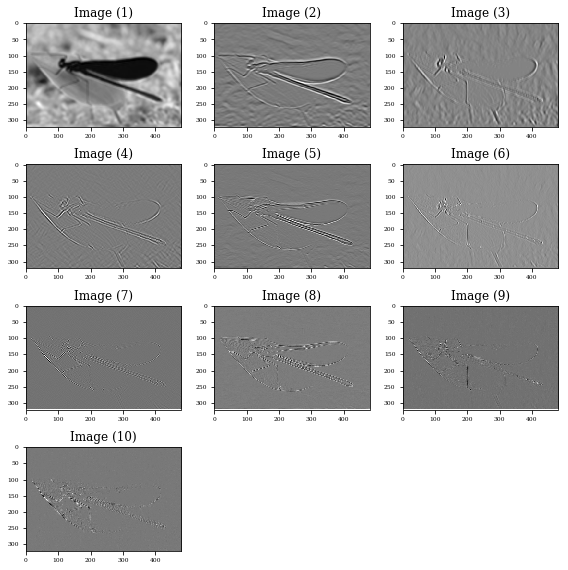

In [48]:
channel_1_images = []
for i in range(transformed.shape[2]):
    channel_1_images.append(transformed[:,:,i])
show_images(channel_1_images, cols = 4 )

In [49]:
h,g = im.wavelet('db2')
image_directory = 'assets/dragonfly.png'
x0 =  plt.imread(image_directory )

channel_1 = udwt(x0[:,:,0],3,h,g)
channel_2 = udwt(x0[:,:,1],3,h,g)
channel_3 = udwt(x0[:,:,2],3,h,g)


transformed_1 = fb_apply(x0[:,:,0], banks)
transformed_2 = fb_apply(x0[:,:,1], banks)
transformed_3 = fb_apply(x0[:,:,2], banks)



In [50]:
print('Filter banks method and convolution method equivalent?: ', np.allclose(channel_1,transformed_1,atol = 1e-6))
print('Filter banks method and convolution method equivalent?: ', np.allclose(channel_2,transformed_2,atol = 1e-6))
print('Filter banks method and convolution method equivalent?: ', np.allclose(channel_3,transformed_3,atol = 1e-6))

Filter banks method and convolution method equivalent?:  True
Filter banks method and convolution method equivalent?:  True
Filter banks method and convolution method equivalent?:  True


# Q20

In [51]:
from imagetools import projectC as c

```
class UDWT(LinearOperator):
    def __init__(self, shape, J, name = 'db2' , using_fb = True):
        self.__ishape = shape
        self.__using_fb = using_fb
        self.__J = J
        h, g = wavelet(name)
        self.__h = h
        self.__g = g
        LinearOperator.__init__(self, shape, shape)
        
    def iudwt(self, z):
        h = self.__h
        g = self.__g
        J = self.__J
        if J == 0:
            try:
                return z[:,:,0]
            except IndexError:
                return z
        h2 = np.zeros((2*h.shape[0]-1,1))
        g2 = np.zeros((2*g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = J - 1
        coarse = self.iudwt(z[:, :, :-3])
        tmpg = convolve(coarse, g[::-1]) + convolve(z[:, :, -3], h[::-1])
        tmph = convolve(z[:, :, -2], g[::-1]) + convolve(z[:, :, -1], h[::-1])
        x = (np.swapaxes(convolve(np.swapaxes(tmpg,0,1), g[::-1]),0,1) + np.swapaxes(convolve(np.swapaxes(tmph,0,1),h[::-1]),0,1))/2
        self.__h = h
        self.__g = g
        self.__J = J
        return x


    def __call__(self, x):
        h = self.__h
        g = self.__g
        J = self.__J
        if self.__using_fb == True :
            filter_bank = self.udwt_create_fb()
            return fb_apply(x, filter_bank)
        if J == 0:
            return x[:, :, np.newaxis]
        tmph = np.swapaxes(convolve(np.swapaxes(x,0,1), h),0,1) / 2
        tmpg = np.swapaxes(convolve(np.swapaxes(x,0,1), g),0,1) / 2
        detail = np.stack((convolve(tmpg, h),
        convolve(tmph, g),
        convolve(tmph, h)), axis=2)
        coarse = convolve(tmpg, g)
        h2 = np.zeros((2*h.shape[0]-1,1))
        g2 = np.zeros((2*g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = J - 1
        z = np.concatenate((self.__call__(coarse), detail), axis=2)
        self.__h = h
        self.__g = g
        self.__J = J
        return z
    
    def udwt_create_fb(self, ndim=3):
        h = self.__h
        g = self.__g
        J = self.__J
        ishape = self.__ishape
        n1, n2 = ishape[:2]
        if J == 0:
            return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
        h2 = np.zeros((2*self.__h.shape[0]-1,1))
        g2 = np.zeros((2*self.__g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = self.__J - 1
        fbrec = self.udwt_create_fb(ndim = ndim)
        gf1 = kernel2fft(g,n1,1)
        hf1 = kernel2fft(h,n1,1)
        gf2 = kernel2fft(g,n2,1)
        hf2 = kernel2fft(h,n2,1)
        fb = np.zeros((n1, n2, 4), dtype=np.complex128)
        fb[:, :, 0] = np.outer(gf1, gf2) / 2
        fb[:, :, 1] = np.outer(gf1, hf2) / 2
        fb[:, :, 2] = np.outer(hf1, gf2) / 2
        fb[:, :, 3] = np.outer(hf1, hf2) / 2
        fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
        fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),
        axis=2)
        self.__h = h
        self.__g = g
        self.__J = J
        return fb
        
    def invert(self, x):
        return np.linalg.pinv(x)
        
    def power(self):
        return udwt_power(self.__J)

    def adjoint(self, x):
        return self.iudwt(x)

    def gram(self, x):
        return self.adjoint(self.__call__(x))

    def gram_resolvent(self, x, tau):
        #return cg(lambda z: z + tau * self.gram(z), x)
        # reduced to:
        #return cg(lambda z: z + tau * self.gram(z), x)
        return x/(1+tau)
    
```

In [52]:
J = 3 
image_directory = 'assets/dragonfly.png'
x0 =  plt.imread(image_directory )
shape = x0.shape[:2]

W_method1 = im.UDWT(shape, J, 'db2', using_fb = True)
W_method2 = im.UDWT(shape, J, 'db2', using_fb = False)

# Q21

# Part 4 - Wavelet Based Imaged Restoration

# Q22

In [53]:
# page 154/104 gives details on sparse regularization    
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255,
                                   gamma=1, return_energy=False, show_progress=False):
    if H is None:
        H_sparse = im.Identity(y.shape)
    else:
        H_sparse = H
            
    class ADMM:
        def __init__(self):
            self.list_lambda = (alpha * W.power()) # see q13, list_lambda contains list of lambda_i
            self.Lambda = np.diag(np.reciprocal(self.list_lambda.flatten())) # (note capital) Lambda^(-1/2).
            self.m = y.size

            self._x = H_sparse.adjoint(y)
            self._z = W(self._x)
            self._dx , self._dz = 0 , 0

        def update(self, m,return_energy=False):
            # update m times
            if return_energy:
                e = []
                
            for i in range(m):
                x = H_sparse.gram_resolvent(self._x + self._dx + gamma * H_sparse.adjoint(y), tau=gamma)
                if i==0:
                    self.n = W(x).size
                    self.tau = np.sqrt(2*np.sqrt(self.m/self.n)) * (sig**2)
                
                z = im.softthresh(self._z + self._dz, (gamma*self.tau) / self.list_lambda)
                self._x = W.gram_resolvent(x - self._dx + W.adjoint(z - self._dz), tau=1)
                self._z = W(self._x)
                self._dx = self._dx - x + self._x
                self._dz = self._dz - z + self._z
                
                if show_progress:
                    print('psnr at step {}: '.format(i),im.psnr(x0,x),sep=' ',end='\t')
                    
                if return_energy:
                    e.append(self.energy(x))
                    
            if show_progress:
                print('final psnr {} dB \n'.format(im.psnr(x0,x)))
                
            if return_energy:
                return x,e
            else:
                return x

        def energy(self,x):
            left_term = np.sum((y - H_sparse(x))**2) / 2
            W_x = W(x)
            try:
                right_term = self.tau*np.sum(np.abs(self.Lambda.dot(W_x)))
            except ValueError:
                right_term = self.tau*np.sum(np.abs(self.Lambda.dot(W_x.reshape(1,self.Lambda.shape[0],W_x.shape[-1]))))
            return left_term + right_term
    
    step = ADMM()
            
    if return_energy:
        x,e = step.update(m,return_energy)
        return x, e
    else:
        x = step.update(m,return_energy)
        return x

# Q23

In [54]:
x0 = plt.imread('assets/dragonfly.png')
x0 = im.dtw_crop(x0,J=3)
sig = 20/255
y = x0 + sig * np.random.randn(*x0.shape)

pnsr for DWT with default parameters is:  30.974023287510036
pnsr for UDWT with default parameters is:  32.80275245235736
looks like UDWT is the best. Below are plots checking that the images were denoised.


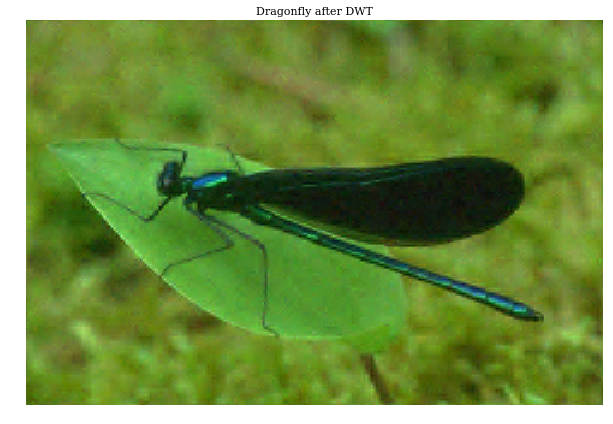

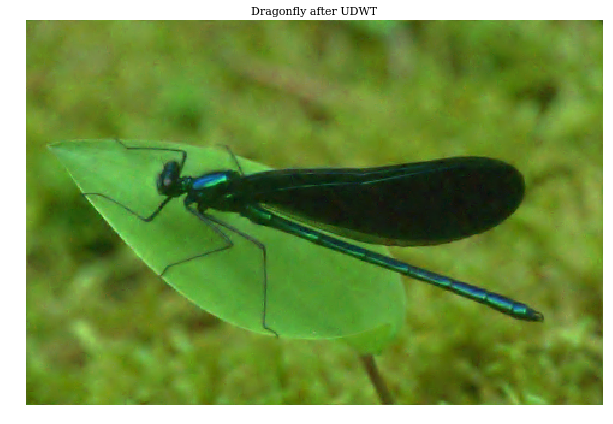

In [55]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y, sig, W_dwt)
print('pnsr for DWT with default parameters is: ', im.psnr(x0,y_dwt))
W_udwt = im.UDWT(y.shape, J=3, name='db2')
y_udwt = sparse_analysis_regularization(y, sig, W_udwt)
print('pnsr for UDWT with default parameters is: ', im.psnr(x0,y_udwt))

print('looks like UDWT is the best. Below are plots checking that the images were denoised.')
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title('Dragonfly after DWT',fontdict = {'fontsize' : 11})
im.show(y_dwt)
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title('Dragonfly after UDWT',fontdict = {'fontsize' : 11})
im.show(y_udwt)

#### note that using_fb=False works as well and gives the same result as expected

In [56]:
W_udwt = im.UDWT(y.shape, J=3, name='db2',using_fb=False)
y_udwt = sparse_analysis_regularization(y, sig, W_udwt)
print('pnsr for UDWT with default parameters is: ', im.psnr(x0,y_udwt))

pnsr for UDWT with default parameters is:  32.80275245235736


### Below we run the DWT and UDWT, printing psnr for every iteration and printing the energy as a list at the end. The first run is for DWT, and the second run is for UDWT. Each run is 20 steps and 50 steps respectively because UDWT takes longer to converge.

# Iterpretation of the results

## Final PSNR
After 40 iterations UDWT gives about 1.8 dB better psnr than DWT.

## Relationship between psnr and energy
Shown below, an increase in psnr corresponds to a decreasing energy at the same time as psnr increases. At every step energy does not necessarily decrease and psnr does not necessarily increase but they tend to decrease/increase more than they increase/decrease so the final pnsr tends to get better the more iterations there are. However, after a around 20 iterations for DWT and 50 iterations for UDWT psnr does not get any better at all since the energy converges.

## About how many iterations are required before the energy plateaus?

- For both DWT and UDWT the energy decreases sharply for the first 5 iterations and start to decrease by increasingly smaller and smaller amounts over time. 

- For DWT, energy approximately plateaus at around single value at around iteration 10 ("step" 9). At this point onwards, energy swings within ~1-2 units. This corresponds to a 2 decimal point swing for the psnr after iteration 10.

- For UDWT, the energy approximately plateaus at iteration 10 as well, however will keep decreasing after that for about 30 more iterations. However, just like DWT the energy will only move by at most ~1-2 units after iteration 10.

- Eventually after 100s of iterations energy will not change at all due to the limited floating point precision of numpy

### DWT

In [57]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
_,e1 = sparse_analysis_regularization(y, sig, W_dwt,m=20,return_energy=True,show_progress=True)
print('list containing energy at each iteration: ',e1)

psnr at step 0:  22.083584673083504	psnr at step 1:  26.956539243300757	psnr at step 2:  29.84014076626877	psnr at step 3:  30.830909345417336	psnr at step 4:  31.027182712443153	psnr at step 5:  31.032225361908168	psnr at step 6:  31.01093564437413	psnr at step 7:  30.994411292647474	psnr at step 8:  30.984697069682227	psnr at step 9:  30.97947969294246	psnr at step 10:  30.97678131294049	psnr at step 11:  30.975409748791098	psnr at step 12:  30.974718379393337	psnr at step 13:  30.97437129864784	psnr at step 14:  30.974197409361924	psnr at step 15:  30.974110377503013	psnr at step 16:  30.974066839771112	psnr at step 17:  30.974045065454746	psnr at step 18:  30.974034176933984	psnr at step 19:  30.974028732332958	final psnr 30.974028732332958 dB 

list containing energy at each iteration:  [6294.443406699621, 3853.3395959306968, 2888.335950727617, 2469.7211931714237, 2276.385580654664, 2183.7107159616185, 2138.3715190064286, 2115.9514793766666, 2104.803849273744, 2099.245631650273, 2

### UDWT

In [58]:
W_udwt = im.UDWT(y.shape, J=3, name='db2')
_,e2 = sparse_analysis_regularization(y, sig, W_udwt,m=50,return_energy=True,show_progress=True)
print('list containing energy at each iteration: ',e2)

psnr at step 0:  22.083584673083504	psnr at step 1:  26.111125879814402	psnr at step 2:  29.018560094903787	psnr at step 3:  30.709878961439895	psnr at step 4:  31.565753275136533	psnr at step 5:  31.992408820947986	psnr at step 6:  32.22026121382958	psnr at step 7:  32.35428241453868	psnr at step 8:  32.440816380435834	psnr at step 9:  32.501123165979365	psnr at step 10:  32.545728715694125	psnr at step 11:  32.5802586650267	psnr at step 12:  32.607988907275896	psnr at step 13:  32.6308952823176	psnr at step 14:  32.65019670088057	psnr at step 15:  32.66674229386486	psnr at step 16:  32.68111951848471	psnr at step 17:  32.69369370382578	psnr at step 18:  32.704797872625754	psnr at step 19:  32.71465234965193	psnr at step 20:  32.72344029367015	psnr at step 21:  32.73133405189495	psnr at step 22:  32.73847835235785	psnr at step 23:  32.74499775533947	psnr at step 24:  32.75095076360884	psnr at step 25:  32.756406041410436	psnr at step 26:  32.761429912978656	psnr at step 27:  32.766088

## Here we plot similar to Q23

In [59]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
W_udwt = im.UDWT(y.shape, J=3, name='db2')
y1 = im.softthresh_denoise(y,sig,W_dwt,alpha=10/255)
y2 = im.softthresh_denoise(y,sig,W_udwt,alpha=10/255)

images for Q4


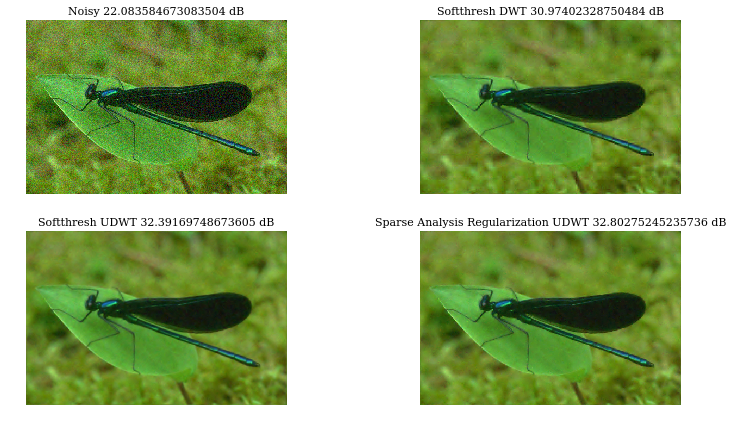

In [60]:
# plot as in q23
# y is noisy image
# y1, y2 are softthresh_denoise
# y_udwt is image after Sparse Analysis Regularization with W=UDWT, m=40
fig,ax = plt.subplots(2, 2,figsize=(14,6))
im.show(y,ax=ax[0,0])
ax[0,0].set_title('Noisy {} dB'.format(im.psnr(x0,y)),fontdict = {'fontsize' : 11})
im.show(y1,ax=ax[0,1])
ax[0,1].set_title('Softthresh DWT {} dB'.format(im.psnr(x0,y1)),fontdict = {'fontsize' : 11})
im.show(y2,ax=ax[1,0])
ax[1,0].set_title('Softthresh UDWT {} dB'.format(im.psnr(x0,y2)),fontdict = {'fontsize' : 11})
im.show(y_udwt,ax=ax[1,1])
ax[1,1].set_title('Sparse Analysis Regularization UDWT {} dB'.format(im.psnr(x0,y_udwt)),fontdict = {'fontsize' : 11})
print('images for Q4')

# Q24 - recovering from motion blur

In [61]:
x0 = plt.imread('assets/topgun.png')
x0 = im.dtw_crop(x0,J=3)
new_sig = 2/255
H_conv = im.Convolution(y.shape,nu=motion_kernel) 
# add noise to the blurry image
y1 = H_conv(x0) + new_sig * np.random.randn(*x0.shape)

## Plot results as in q24

In [62]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y1, new_sig, W_dwt,H=H_conv,gamma=100)
W_udwt = im.UDWT(y.shape, J=3, name='db2')
y_udwt = sparse_analysis_regularization(y1, new_sig, W_udwt,H=H_conv,gamma=100)

Text(0.5,1,'SAR with UDWT 29.90789854615903 dB ')

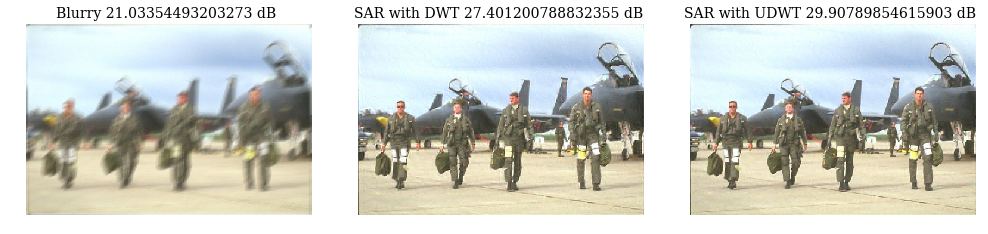

In [63]:
y2 = y_dwt
y3 = y_udwt

fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].set_title('Blurry {} dB '.format(im.psnr(x0,y1)),fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].set_title('SAR with DWT {} dB '.format(im.psnr(x0,y2)),fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].set_title('SAR with UDWT {} dB '.format(im.psnr(x0,y3)),fontdict = {'fontsize' : 14})

# Q25 - recovering from random masking p=0.4

In [64]:
x0 = plt.imread('assets/topgun.png')
x0 = im.dtw_crop(x0,J=3)
new_sig = 2/255
H_rm = im.RandomMasking(y.shape,p=0.4)
# add noise to the blurry image
y1 = H_rm(x0) + new_sig * np.random.randn(*x0.shape)

## Plot results as in q25

In [65]:
W_dwt = im.DWT(y.shape, J=3, name='db2')
y_dwt = sparse_analysis_regularization(y1, new_sig, W_dwt,H=H_rm,gamma=100)
W_udwt = im.UDWT(y.shape, J=3, name='db2')
y_udwt = sparse_analysis_regularization(y1, new_sig, W_udwt,H=H_rm,gamma=100)

Text(0.5,1,'Random Masking: SAR with UDWT 30.42 dB ')

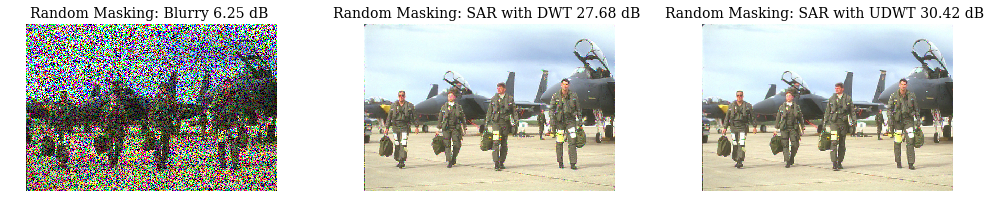

In [66]:
y2 = y_dwt
y3 = y_udwt

fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].set_title('Random Masking: Blurry {:.2f} dB '.format(im.psnr(x0,y1)),fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].set_title('Random Masking: SAR with DWT {:.2f} dB '.format(im.psnr(x0,y2)),fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].set_title('Random Masking: SAR with UDWT {:.2f} dB '.format(im.psnr(x0,y3)),fontdict = {'fontsize' : 14})

# Extra Credit

## We implemented the following - 
## EC-1: In denoising, for different noise levels and parameters, compare your wavelet implementation withthe one of Scikit image:skimage.restoration.denoisewavelet

# EC-1

In [67]:
from skimage.restoration import denoise_wavelet

In [68]:
# synthesis vs analysis is described starting from page 104 and after. 

# imagetools/projectC.py

In [ ]:
""" Project C

COMPLETE THIS FILE

Your names here:
Khoi Nguyen
Justin Law

"""

from .assignment6 import *

class Identity(LinearOperator):
    def __init__(self, shape):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
    def __call__(self, x):
        return x
    
    def adjoint(self, x):
        # note that the adjoint of the identity matrix is the identity matrix itself.
        # it is easy to see this by the definition of a linear operator, noting the commutative property of the inner product    
        return self.__call__(x)

    def gram(self, x):
        # apply the gram matrix to x, which is equivalent to just returning x
        return self.adjoint(self.__call__(x))
    
    def gram_resolvent(self, x, tau):
        # do the inversion by the conjugate gradient
        return cg(lambda z: z + tau * self.gram(z), x)
    
class Convolution(LinearOperator):
    def __init__(self, shape, nu, separable=None):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)

        self._separable = separable
        n1, n2 = ishape[:2]
        self._nu_fft = kernel2fft(nu, n1, n2, separable=self._separable)
        # mu = F^{-1}(conjugate(F(nu))), see assignment 5 for explanation
        self._mu_fft = np.conjugate(self._nu_fft)
        
    def __call__(self, x):
        return convolvefft(x,self._nu_fft)
    
    def adjoint(self, x):
        return convolvefft(x, self._mu_fft)
    
    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to convolvefft(x, nu_fft*mu_fft) by properties of fft
        return convolvefft(x, nu_fft*mu_fft)
    
    def gram_resolvent(self, x, tau):
        # Assuming that boundary is always periodical
        # Just like the Gram LinearOperator, can do the inversion in the Fourier domain when periodical
        # reduced to:
        res_nu = 1 / (1 + tau * self._nu_fft * self._mu_fft)
        return convolvefft(x, res_nu)
    
class RandomMasking(LinearOperator):
    def __init__(self, shape, p):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
        self._apply_random_mask = np.random.choice(np.array([0,1]), size=oshape, p=[p,1-p])
        
    def __call__(self, x):
        # apply pixel by pixel the random mask
        return self._apply_random_mask * x
    
    def adjoint(self, x):
        # easy to see this is self-adjoint by the definition of a linear operator, noting the commutative property of the inner product 
        return self.__call__(x)

    def gram(self, x):
        # can also be reduced to self._apply_random_mask * x because 0*0=0, 1*0 =0, 0*1=0,1*1=1
        return self.adjoint(self.__call__(x))
    
    def gram_resolvent(self, x, tau):
        return cg(lambda z: z + tau * self.gram(z), x)
        
################
# Part 2

def flip (x):
    return np.transpose(x,axes= (1,0,2))

def dwt1d(x, h, g): # 1d and 1scale
    coarse = convolve(x, g)
    detail = convolve(x, h)
    z = np.concatenate((coarse[::2, :], detail[::2, :]), axis=0)
    return z

def dwt(x, J, h, g):
    if J == 0:
        return x
    n1, n2 = x.shape[:2]
    m1, m2 = (int(n1 / 2), int(n2 / 2))
    z = dwt1d(x, h, g)
    z = flip(dwt1d(flip(z), h, g))
    z[:m1, :m2] = dwt(z[:m1, :m2], J - 1, h, g)
    return z

def idwt(z, J, h, g): # 2d and multi-scale
    if J == 0:
        return z
    n1, n2 = z.shape[:2]
    m1, m2 = (int(n1 / 2), int(n2 / 2))
    x = z.copy()
    x[:m1, :m2] = idwt(x[:m1, :m2], J - 1, h, g)
    x = flip(idwt1d(flip(x), h, g))
    x = idwt1d(x, h, g)
    return x

def idwt1d(z, h, g): # 1d and 1scale
    n1 = z.shape[0]
    m1 = int(n1 / 2)
    coarse, detail = np.zeros(z.shape), np.zeros(z.shape)
    coarse[::2, :], detail[::2, :] = z[:m1, :], z[m1:, :]
    x = convolve(coarse, g[::-1]) + convolve(detail, h[::-1])
    return x
    
def shift(x, k, l, boundary):
    n1,n2 = x.shape[:2]
    xshifted = np.zeros(x.shape)
    if boundary is 'periodical':
        irange = np.mod(np.arange(n1) + k, n1)
        jrange = np.mod(np.arange(n2) + l, n2)
        xshifted = x[irange, :][:, jrange]
        
    if boundary is 'extension':
        irange = np.concatenate((np.zeros(max(-k,0), dtype = np.int32 ),np.arange(max(k,0), n1-max(-k,0)),
                                 (n1 - 1)* np.ones(max(k,0), dtype = np.int32)))
        jrange = np.concatenate((np.zeros(max(-l,0), dtype = np.int32),
                                 np.arange(max(l,0), n2-max(-l,0)),
                                 (n2 - 1)* np.ones(max(l,0), dtype = np.int32)))
        return x[irange, :][:, jrange]
    
    if boundary is 'mirror':
        irange = np.concatenate((np.arange(max(-k,0), 0, -1),np.arange(max(k,0), n1-max(-k,0)),
                                 (n1 - 1) - np.arange(0,max(k,0))))
        jrange = np.concatenate((np.arange(max(-l,0), 0, -1),
                                 np.arange(max(l,0), n2-max(-l,0)),
                                 (n2 - 1) - np.arange(0,max(l,0))))
        return x[irange, :][:, jrange]
    
    if boundary is 'zero-padding':
        if k < 0 :
            xshifted = np.roll(x,-k,axis = 0)
            xshifted[0:-k,:,:] = 0
        elif k>=0:
            xshifted = np.roll(x,-k, axis = 0)
            xshifted[n1-k:n1,:,:] = 0
        if l>=0:
            xshifted = np.roll(xshifted, -l, axis = 1)
            xshifted[:,n2-l:n2,:] = 0
        elif l<0:
            xshifted = np.roll(xshifted, -l, axis = 1)
            xshifted[:,0:-l,:] = 0
    return xshifted 

def convolve(x, nu, boundary='periodical', seperable='None'):
    xconv = np.zeros(x.shape)
    if seperable == 'None':
        s1 = int((nu.shape[0] - 1) / 2)
        s2 = int((nu.shape[1] - 1) / 2)
        for k in range(-s1, s1+1):
            for l in range(-s2, s2+1):
                xconv += nu[k+s1,l+s2]*shift(x,-k,-l,boundary )       
    elif seperable == 'product':
        xtemp = np.zeros(x.shape)
        s1 = int((nu[0].shape[0] - 1) / 2)
        s2 = int((nu[1].shape[1] - 1) / 2)
        for l in range(-s2, s2+1):
            xtemp += nu[1][0,l+s2]*shift(x,0,-l,boundary )
        for k in range(-s1, s1+1):
            xconv += nu[0][k+s1,0]*shift(xtemp,-k,0,boundary )
    elif seperable == 'sum':
        s1 = int((nu[0].shape[0] - 1) / 2)
        s2 = int((nu[1].shape[1] - 1) / 2)
        for k in range(-s1, s1+1):
            xconv += nu[0][k+s1,0]*shift(x,-k,0,boundary )
        for l in range(-s2, s2+1):
            xconv += nu[1][0,l+s2]*shift(x,0,-l,boundary )
    return xconv


def dwt_power(n1, n2, J, ndim=3):

    if J == 0:
        return np.ones((n1, n2, *[1] * (ndim - 2)))
    m1, m2 = int(n1/2), int(n2/2)
    c = 2 * dwt_power(m1, m2, J - 1, ndim=ndim)
    de = np.ones((m1, m2, *[1] * (ndim - 2)))
    p = np.concatenate((np.concatenate((c, de), axis=0),
                        np.concatenate((de, de), axis=0)), axis=1)
    return p

class DWT:
    def __init__(self, shape, J, name):
        self.name = name
        self.J = J
        self.shape=shape
        h,g = wavelet(self.name)
     
    def __call__(self, x):
        h,g = wavelet(self.name)
        z_dwt = dwt(x,self.J,h,g)
        return z_dwt
    
    def invert(self,x):
        h,g = wavelet(self.name)
        return idwt(x,self.J,h,g)
    
    def power(self):
        n1,n2= self.shape[:2]
        J= self.J
        return dwt_power(n1, n2, self.J, ndim=len(self.shape))

    def adjoint(self, x):
        return self.invert(x)

    def gram(self, x):
        return self.adjoint(self.__call__(x))

    def gram_resolvent(self, x, tau):
        #return cg(lambda z: z + tau * self.gram(z), x)
        # reduced to:
        return x/(1+tau)
   
    def wavelet(name, d=2):
    
        if name in ('haar', 'db1'):
            h = np.array([-1, 1])
        if name is 'db2':
            h = np.array([1, np.sqrt(3), -(3 + 2 * np.sqrt(3)), 2 + np.sqrt(3)])
        if name is 'db4':
            h = np.array(
            [-0.230377813308855230, +0.714846570552541500, -0.630880767929590400,
             -0.027983769416983850, +0.187034811718881140, +0.030841381835986965,
             -0.032883011666982945, -0.010597401784997278])
        if name is 'db8':
            h = np.array(
            [-0.0544158422, +0.3128715909, -0.6756307363, +0.5853546837,
             +0.0158291053, -0.2840155430, -0.0004724846, +0.1287474266,
             +0.0173693010, -0.0440882539, -0.0139810279, +0.0087460940,
             +0.0048703530, -0.0003917404, -0.0006754494, -0.0001174768])
        if name is 'sym4':
            h = np.array(
            [-0.03222310060404270, -0.012603967262037833, +0.09921954357684722,
             +0.29785779560527736, -0.803738751805916100, +0.49761866763201545,
             +0.02963552764599851, -0.075765714789273330])
        if name is 'coif4':
            h = np.array(
            [-0.00089231366858231460, -0.00162949201260173260, +0.00734616632764209350,
             +0.01606894396477634800, -0.02668230015605307200, -0.08126669968087875000,
             +0.05607731331675481000, +0.41530840703043026000, -0.78223893092049900000,
             +0.43438605649146850000, +0.06662747426342504000, -0.09622044203398798000,
             -0.03933442712333749000, +0.02508226184486409700, +0.01521173152794625900,
             -0.00565828668661072000, -0.00375143615727845700, +0.00126656192929894450,
             +0.00058902075624433830, -0.00025997455248771324, -6.2339034461007130e-05,
             +3.1229875865345646e-05, +3.2596802368833675e-06, -1.7849850030882614e-06])
        h = h / np.sqrt(np.sum(h**2))
        g = (-1)**(1 + np.arange(h.shape[0])) * h[::-1]
        h = np.concatenate((h, np.array([0.])))
        g = np.concatenate((g, np.array([0.])))
        h = h.reshape(-1, *[1] * (d - 1))
        g = g.reshape(-1, *[1] * (d - 1))
        return h, g
    
    def dtw_crop(x, J):
        n1, n2 = x.shape[:2]
        r1 = np.mod(n1, 2**J)
        r2 = np.mod(n2, 2**J)
        if r1 > 0:
            x = x[int(r1/2):-(r1-int(r1/2)), :]
        if r2 > 0:
            x = x[:, int(r2/2):-(r2-int(r2/2))]
        return x

def softthresh(z, t):
    new_z = (z - np.sign(z-t) * t) * np.maximum(np.abs(z)-t,0).astype(bool)
    
    return new_z

def softthresh_denoise(y, sig, W, alpha):
    p=W.power()
    lamda=np.zeros(p.shape)
    tau=np.zeros(p.shape)
    lamda = alpha*p
    tau= (np.sqrt(2)*(sig**2))/lamda
    
    #z=dtw_crop(y,J)
    z = W(y)
    z_denoise = softthresh(z,tau)
    # adjoint is inverse transform for both DWT and UDWT
    denoise = W.adjoint(z_denoise)
    return denoise

################################################ 
####### part 3

def wavelet(name, d=2):
    if name in ('haar', 'db1'):
        h = np.array([-1, 1])
    if name is 'db2':
        h = np.array([1, np.sqrt(3), -(3 + 2 * np.sqrt(3)), 2 + np.sqrt(3)])
    if name is 'db4':
        h = np.array(
            [-0.230377813308855230, +0.714846570552541500, -0.630880767929590400,
            -0.027983769416983850, +0.187034811718881140, +0.030841381835986965,
            -0.032883011666982945, -0.010597401784997278])
    if name is 'db8':
        h = np.array(
            [-0.0544158422, +0.3128715909, -0.6756307363, +0.5853546837,
            +0.0158291053, -0.2840155430, -0.0004724846, +0.1287474266,
            +0.0173693010, -0.0440882539, -0.0139810279, +0.0087460940,
            +0.0048703530, -0.0003917404, -0.0006754494, -0.0001174768])
    if name is 'sym4':
        h = np.array(
            [-0.03222310060404270, -0.012603967262037833, +0.09921954357684722,
            +0.29785779560527736, -0.803738751805916100, +0.49761866763201545,
            +0.02963552764599851, -0.075765714789273330])
    if name is 'coif4':
        h = np.array(
            [-0.00089231366858231460, -0.00162949201260173260, +0.00734616632764209350,
            +0.01606894396477634800, -0.02668230015605307200, -0.08126669968087875000,
            +0.05607731331675481000, +0.41530840703043026000, -0.78223893092049900000,
            +0.43438605649146850000, +0.06662747426342504000, -0.09622044203398798000,
            -0.03933442712333749000, +0.02508226184486409700, +0.01521173152794625900,
            -0.00565828668661072000, -0.00375143615727845700, +0.00126656192929894450,
            +0.00058902075624433830, -0.00025997455248771324, -6.2339034461007130e-05,
            +3.1229875865345646e-05, +3.2596802368833675e-06, -1.7849850030882614e-06])
    h = h / np.sqrt(np.sum(h**2))
    g = (-1)**(1 + np.arange(h.shape[0])) * h[::-1]
    h = np.concatenate((h, np.array([0.])))
    g = np.concatenate((g, np.array([0.])))
    h = h.reshape(-1, *[1] * (d - 1))
    g = g.reshape(-1, *[1] * (d - 1))
    return h, g

def udwt_power(J, ndim=3):
    p = ((4)**J, )
    for j in range(1, J+1):
        p += ((4)**(J - j), ) * 3
    p = np.array(p, dtype=np.float32).reshape(1, 1, -1, *[1] * (ndim - 2))
    p[:, :, 1:] *= 2
    return p

def fb_apply(x, fb):
    x = npf.fft2(x, axes=(0, 1))
    if x.ndim == 3:
        z = fb * x[:, :, np.newaxis,:]
    else:
        z = fb * x[:, :, np.newaxis]
    z = np.real(npf.ifft2(z, axes=(0, 1)))
    for i in range(1,fb.shape[2],int((fb.shape[2]-1)/3)):
        temp = np.copy(z[:,:,i])
        z[:,:,i] = z[:,:,i+1]
        z[:,:,i+1] = temp
    return z

def fb_adjoint(z, fb):
    z = npf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(npf.ifft2(x, axes=(0, 1)))
    return x

class UDWT(LinearOperator):
    def __init__(self, shape, J, name = 'db2' , using_fb = True):
        self.__ishape = shape
        self.__using_fb = using_fb
        self.__J = J
        h, g = wavelet(name)
        self.__h = h
        self.__g = g
        LinearOperator.__init__(self, shape, shape)
        
    def iudwt(self, z):
        h = self.__h
        g = self.__g
        J = self.__J
        if J == 0:
            try:
                return z[:,:,0]
            except IndexError:
                return z
        h2 = np.zeros((2*h.shape[0]-1,1))
        g2 = np.zeros((2*g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = J - 1
        coarse = self.iudwt(z[:, :, :-3])
        tmpg = convolve(coarse, g[::-1]) + convolve(z[:, :, -3], h[::-1])
        tmph = convolve(z[:, :, -2], g[::-1]) + convolve(z[:, :, -1], h[::-1])
        x = (np.swapaxes(convolve(np.swapaxes(tmpg,0,1), g[::-1]),0,1) + np.swapaxes(convolve(np.swapaxes(tmph,0,1),h[::-1]),0,1))/2
        self.__h = h
        self.__g = g
        self.__J = J
        return x


    def __call__(self, x):
        h = self.__h
        g = self.__g
        J = self.__J
        if self.__using_fb == True :
            filter_bank = self.udwt_create_fb()
            return fb_apply(x, filter_bank)
        if J == 0:
            return x[:, :, np.newaxis]
        tmph = np.swapaxes(convolve(np.swapaxes(x,0,1), h),0,1) / 2
        tmpg = np.swapaxes(convolve(np.swapaxes(x,0,1), g),0,1) / 2
        detail = np.stack((convolve(tmpg, h),
        convolve(tmph, g),
        convolve(tmph, h)), axis=2)
        coarse = convolve(tmpg, g)
        h2 = np.zeros((2*h.shape[0]-1,1))
        g2 = np.zeros((2*g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = J - 1
        z = np.concatenate((self.__call__(coarse), detail), axis=2)
        self.__h = h
        self.__g = g
        self.__J = J
        return z
    
    def udwt_create_fb(self, ndim=3):
        h = self.__h
        g = self.__g
        J = self.__J
        ishape = self.__ishape
        n1, n2 = ishape[:2]
        if J == 0:
            return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
        h2 = np.zeros((2*self.__h.shape[0]-1,1))
        g2 = np.zeros((2*self.__g.shape[0]-1,1))
        h2[::2] = h
        g2[::2] = g
        self.__h = h2
        self.__g = g2
        self.__J = self.__J - 1
        fbrec = self.udwt_create_fb(ndim = ndim)
        gf1 = kernel2fft(g,n1,1)
        hf1 = kernel2fft(h,n1,1)
        gf2 = kernel2fft(g,n2,1)
        hf2 = kernel2fft(h,n2,1)
        fb = np.zeros((n1, n2, 4), dtype=np.complex128)
        fb[:, :, 0] = np.outer(gf1, gf2) / 2
        fb[:, :, 1] = np.outer(gf1, hf2) / 2
        fb[:, :, 2] = np.outer(hf1, gf2) / 2
        fb[:, :, 3] = np.outer(hf1, hf2) / 2
        fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
        fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),
        axis=2)
        self.__h = h
        self.__g = g
        self.__J = J
        return fb
        
    def invert(self, x):
        return np.linalg.pinv(x)
        
    def power(self):
        return udwt_power(self.__J)

    def adjoint(self, x):
        return self.iudwt(x)

    def gram(self, x):
        return self.adjoint(self.__call__(x))

    def gram_resolvent(self, x, tau):
        #return cg(lambda z: z + tau * self.gram(z), x)
        # reduced to:
        #return cg(lambda z: z + tau * self.gram(z), x)
        return x/(1+tau)
    
# helper function
# use psnr from assignment 4 for noise dB calculation
def psnr(x, x0):
    R = (255 if np.any(x>1) else 1)
    den = ((x.flatten() - x0.flatten())**2).mean()
    snr = 10*math.log(R**2/den, 10)
    return snr